# Simulation10

**Mengqi Liu**

**Sep 12, 2023**
___

 - Methods:
   ($\tilde{Z}$ is the discretized $Z$, and the data belonging to the same group share the same $\tilde{Z}$.)
   - "double_Z/cor_Z": permute $X$ within each bin. At each time, regress $Y$ on $1,Z$ and regress $X$ on $1,Z$ separately, and take the *absolute* *correlation* between residuals from two linear regressions as the test statistic.
   
   - "XY_meanZ": permute $X$ within each bin. At each time, regress $Y$ on $1,\tilde{Z}$ and regress $X$ on $1,\tilde{Z}$ separately, and take the *absolute* *product* between residuals from two linear regressions as the test statistic.
   
   - "cor_noZ": use $cor(X,Y)$ as test statistic with local permutation in $X$ with respect to $Z$.
   - "XY_Z": regress $Y$ on $1,Z$ and regress $X$ on $1,Z$ separately. Permute residuals from regression on for $X$ and take the *absolute* *product* between residuals as the test statistic.
   - "XY_noZ": use $X^\top Y$ as test statistic with local permutation in $X$ with respect to $Z$.
   

## Summary
 
 - cor_meanZ = XY_meanZ (same denominator) 
 
 - Only using nominator (XY_Z) will improve the ability of cor_Z to control for type-1 error
 
 - cor_noZ != XY_noZ due to non-zero $E(X)$ & $E(Y)$
 
 - noZ has lower power under situtation that at least one of $X$ and $Y$ is smooth. If both are non-smooth, sometimes noZ can have better type-1 error control and power at the same time. noZ & XY_noZ sometimes have catastrophic problem in zero power.
 
 - why XY_Z doesn't gain more power than XY_meanZ? 
 <font color=#008000 >
    
    - too small sample? (N=1000)
    
    - too large M? (M$\leq$25 cannot guarantee type-1 error control) 
    
    - good property of gaussian noise? (skewed normal distribution)
    
    - linear in Z? (both non-linear)</font>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import expfunc
from scipy.stats import percentileofscore

In [2]:
def _perm(V, G, M):
    new_V = V.copy()
    for g in range(M):
        inds = np.where(G==g)[0]
        new_inds = inds.copy()
        np.random.shuffle(new_inds)
        new_V[new_inds] = new_V[inds]
    return new_V

def compute_resid(Z, Y):
    Z1 = sm.add_constant(Z)
    mod = sm.OLS(Y, Z1).fit()
    return mod.resid

def corr(X, Y):
    return np.abs(np.corrcoef(X, Y)[0, 1])

def compute_G(Z, M):
    G = pd.qcut(Z, M, labels=[i for i in range(M)])
    Z_means = [np.mean(Z[G == g]) for g in range(M)]
    return G, np.array([Z_means[G[i]] for i in range(Z.shape[0])])


In [3]:
def perm_var(xfunc, vx):
    X, Y, Z = expfunc.data_generative(N=100, s=1, type="normal", hypo="h0", xfun=xfunc, yfun=expfunc.Z_to_Y, cor=0.4, vx=vx, vy=0.01)
    X_resid_o = compute_resid(Z, X)
    Y_resid_o = compute_resid(Z, Y)
    T_sam = np.std(X_resid_o)

    B = 1000
    Ms = [2, 5, 10, 15, 25, 50]
    T_per_z = np.zeros([len(Ms), B])

    for m in range(len(Ms)):
        #print("Processing M=", Ms[m])
        G, _ = compute_G(Z, Ms[m])
        for i in range(B):
            new_X = _perm(X, G, Ms[m])
            X_resid_temp = compute_resid(Z, new_X)
            T_per_z[m, i] = np.std(X_resid_temp)
    
    return T_sam, T_per_z

## Deviation of SD($P_{Z^{\perp}}X$) to SD($P_{Z^{\perp}}X_\sigma$)

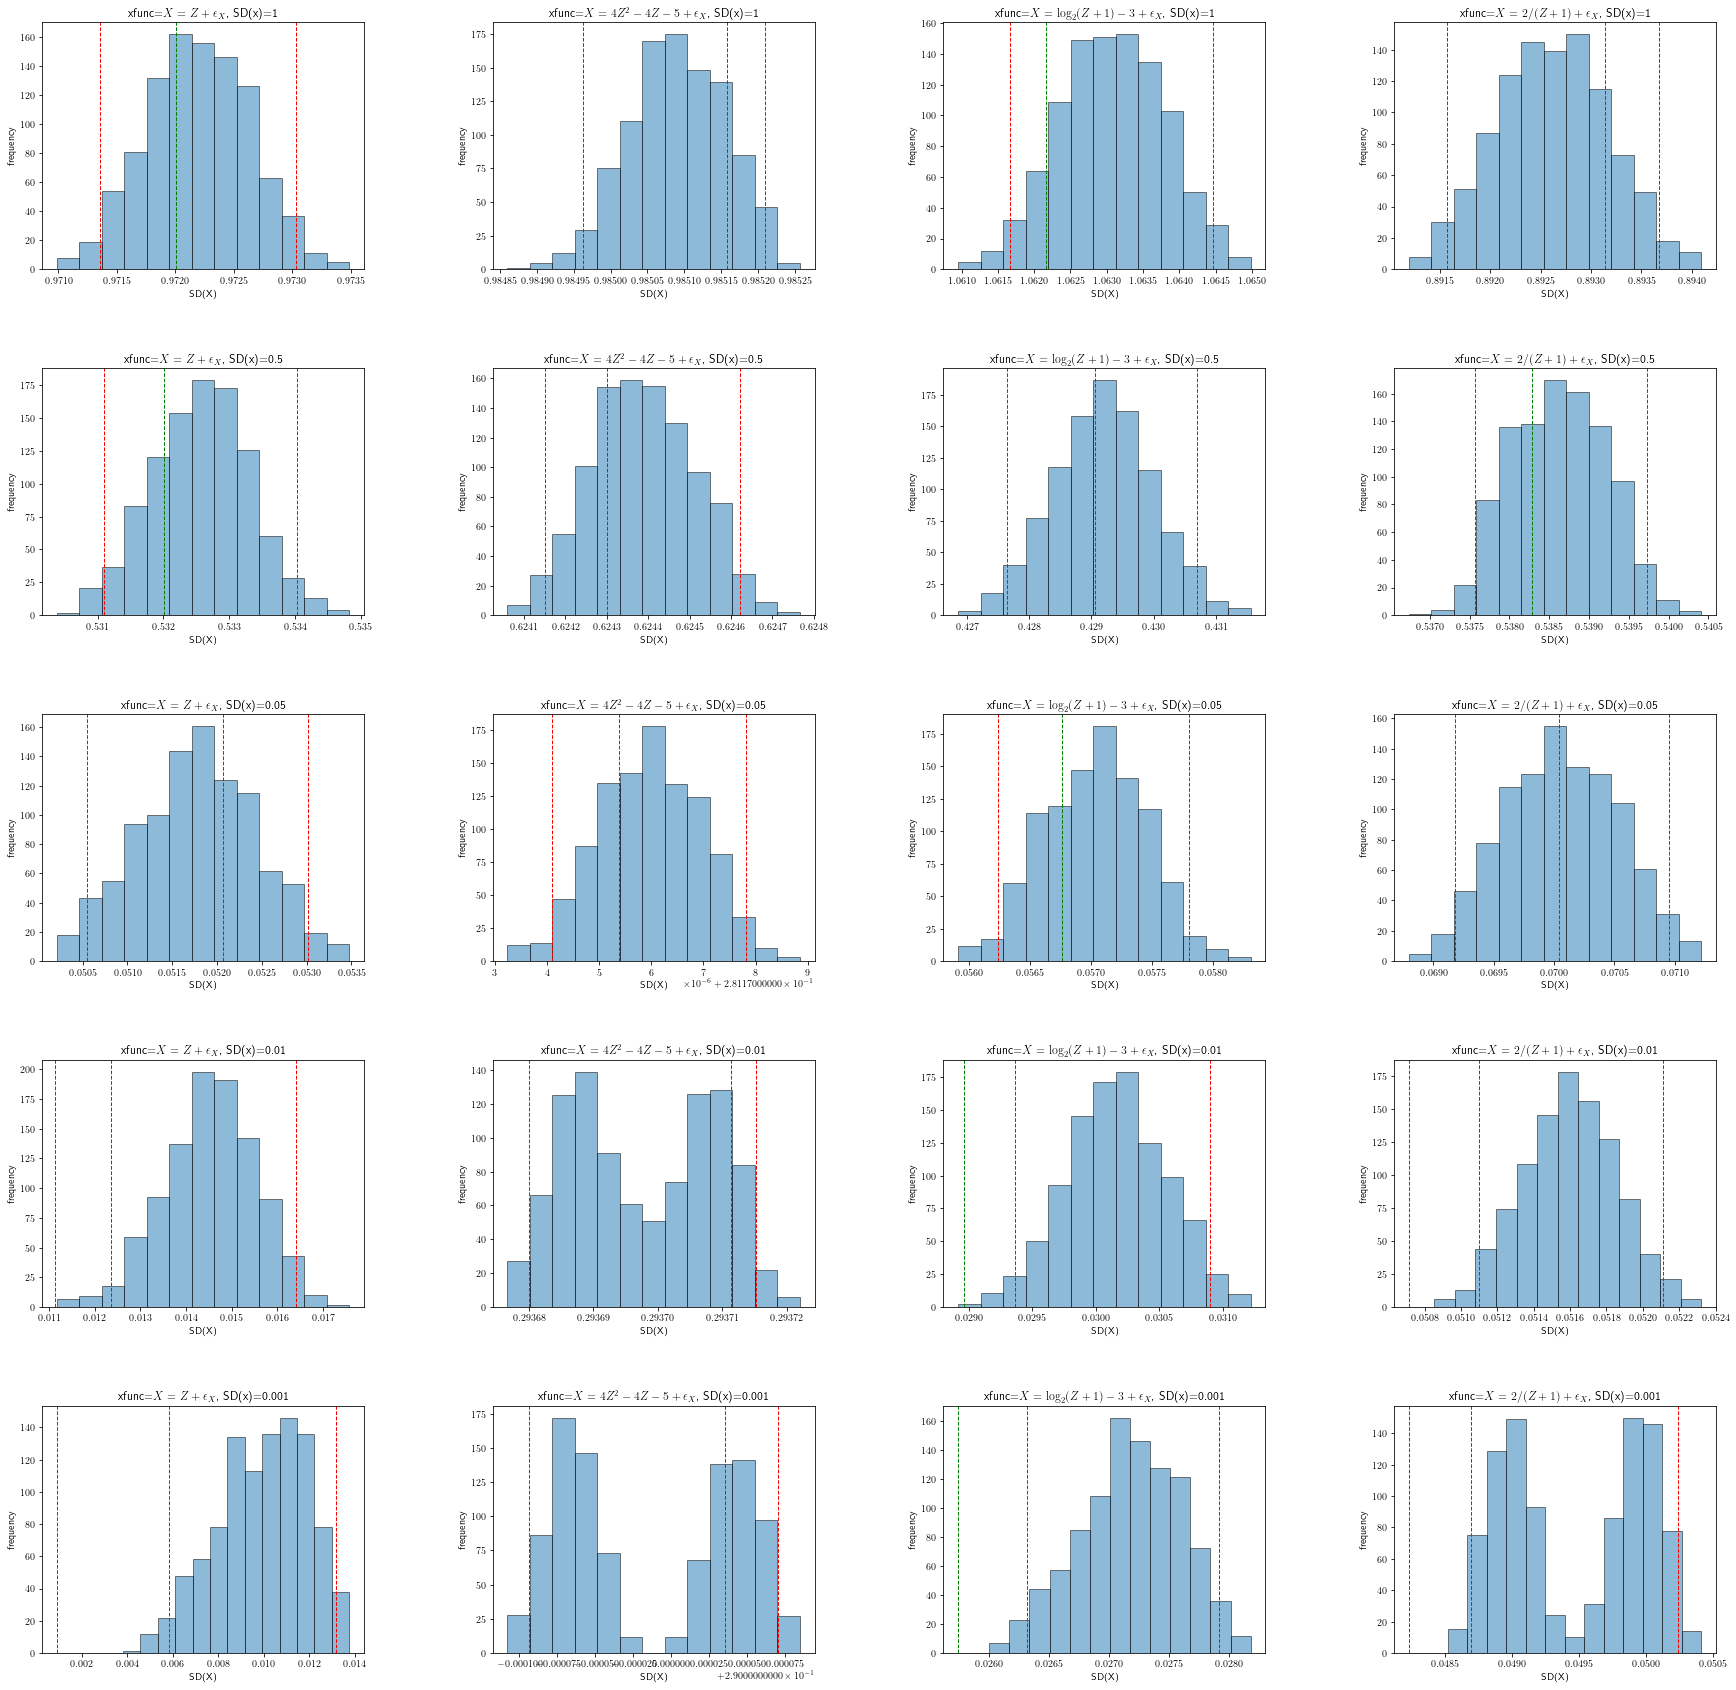

In [35]:
vxs = [1, 0.5, 0.05, 0.01, 0.001]
Ms = [2, 5, 10, 15, 25, 50]
xfuns = [None, expfunc.Z_to_Y, expfunc.Z_to_Y2, expfunc.Z_to_Y3]
xfuns_label = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=.4, hspace=.4)
for vx1 in range(len(vxs)):
    for xf in range(len(xfuns)):
        plt.subplot(5, 4, vx1*4+xf+1)
        T_sam, T_per_z = perm_var(xfuns[xf], vxs[vx1])
        plt.hist(T_per_z[5,:], bins=13, edgecolor='black', alpha=0.5)
        plt.axvline(x=T_sam, color='green', linestyle='--', linewidth=1)
        plt.axvline(x=np.percentile(T_per_z[-1,:], 2.5), color='red', linestyle='--', linewidth=1)
        plt.axvline(x=np.percentile(T_per_z[-1,:], 97.5), color='red', linestyle='--', linewidth=1)
        plt.xlabel("SD(X)")
        plt.ylabel("frequency")
        plt.title(f"xfunc={xfuns_label[xf]}, SD(x)={vxs[vx1]}")
plt.show()

## Original results (transformed to cor-power plot)

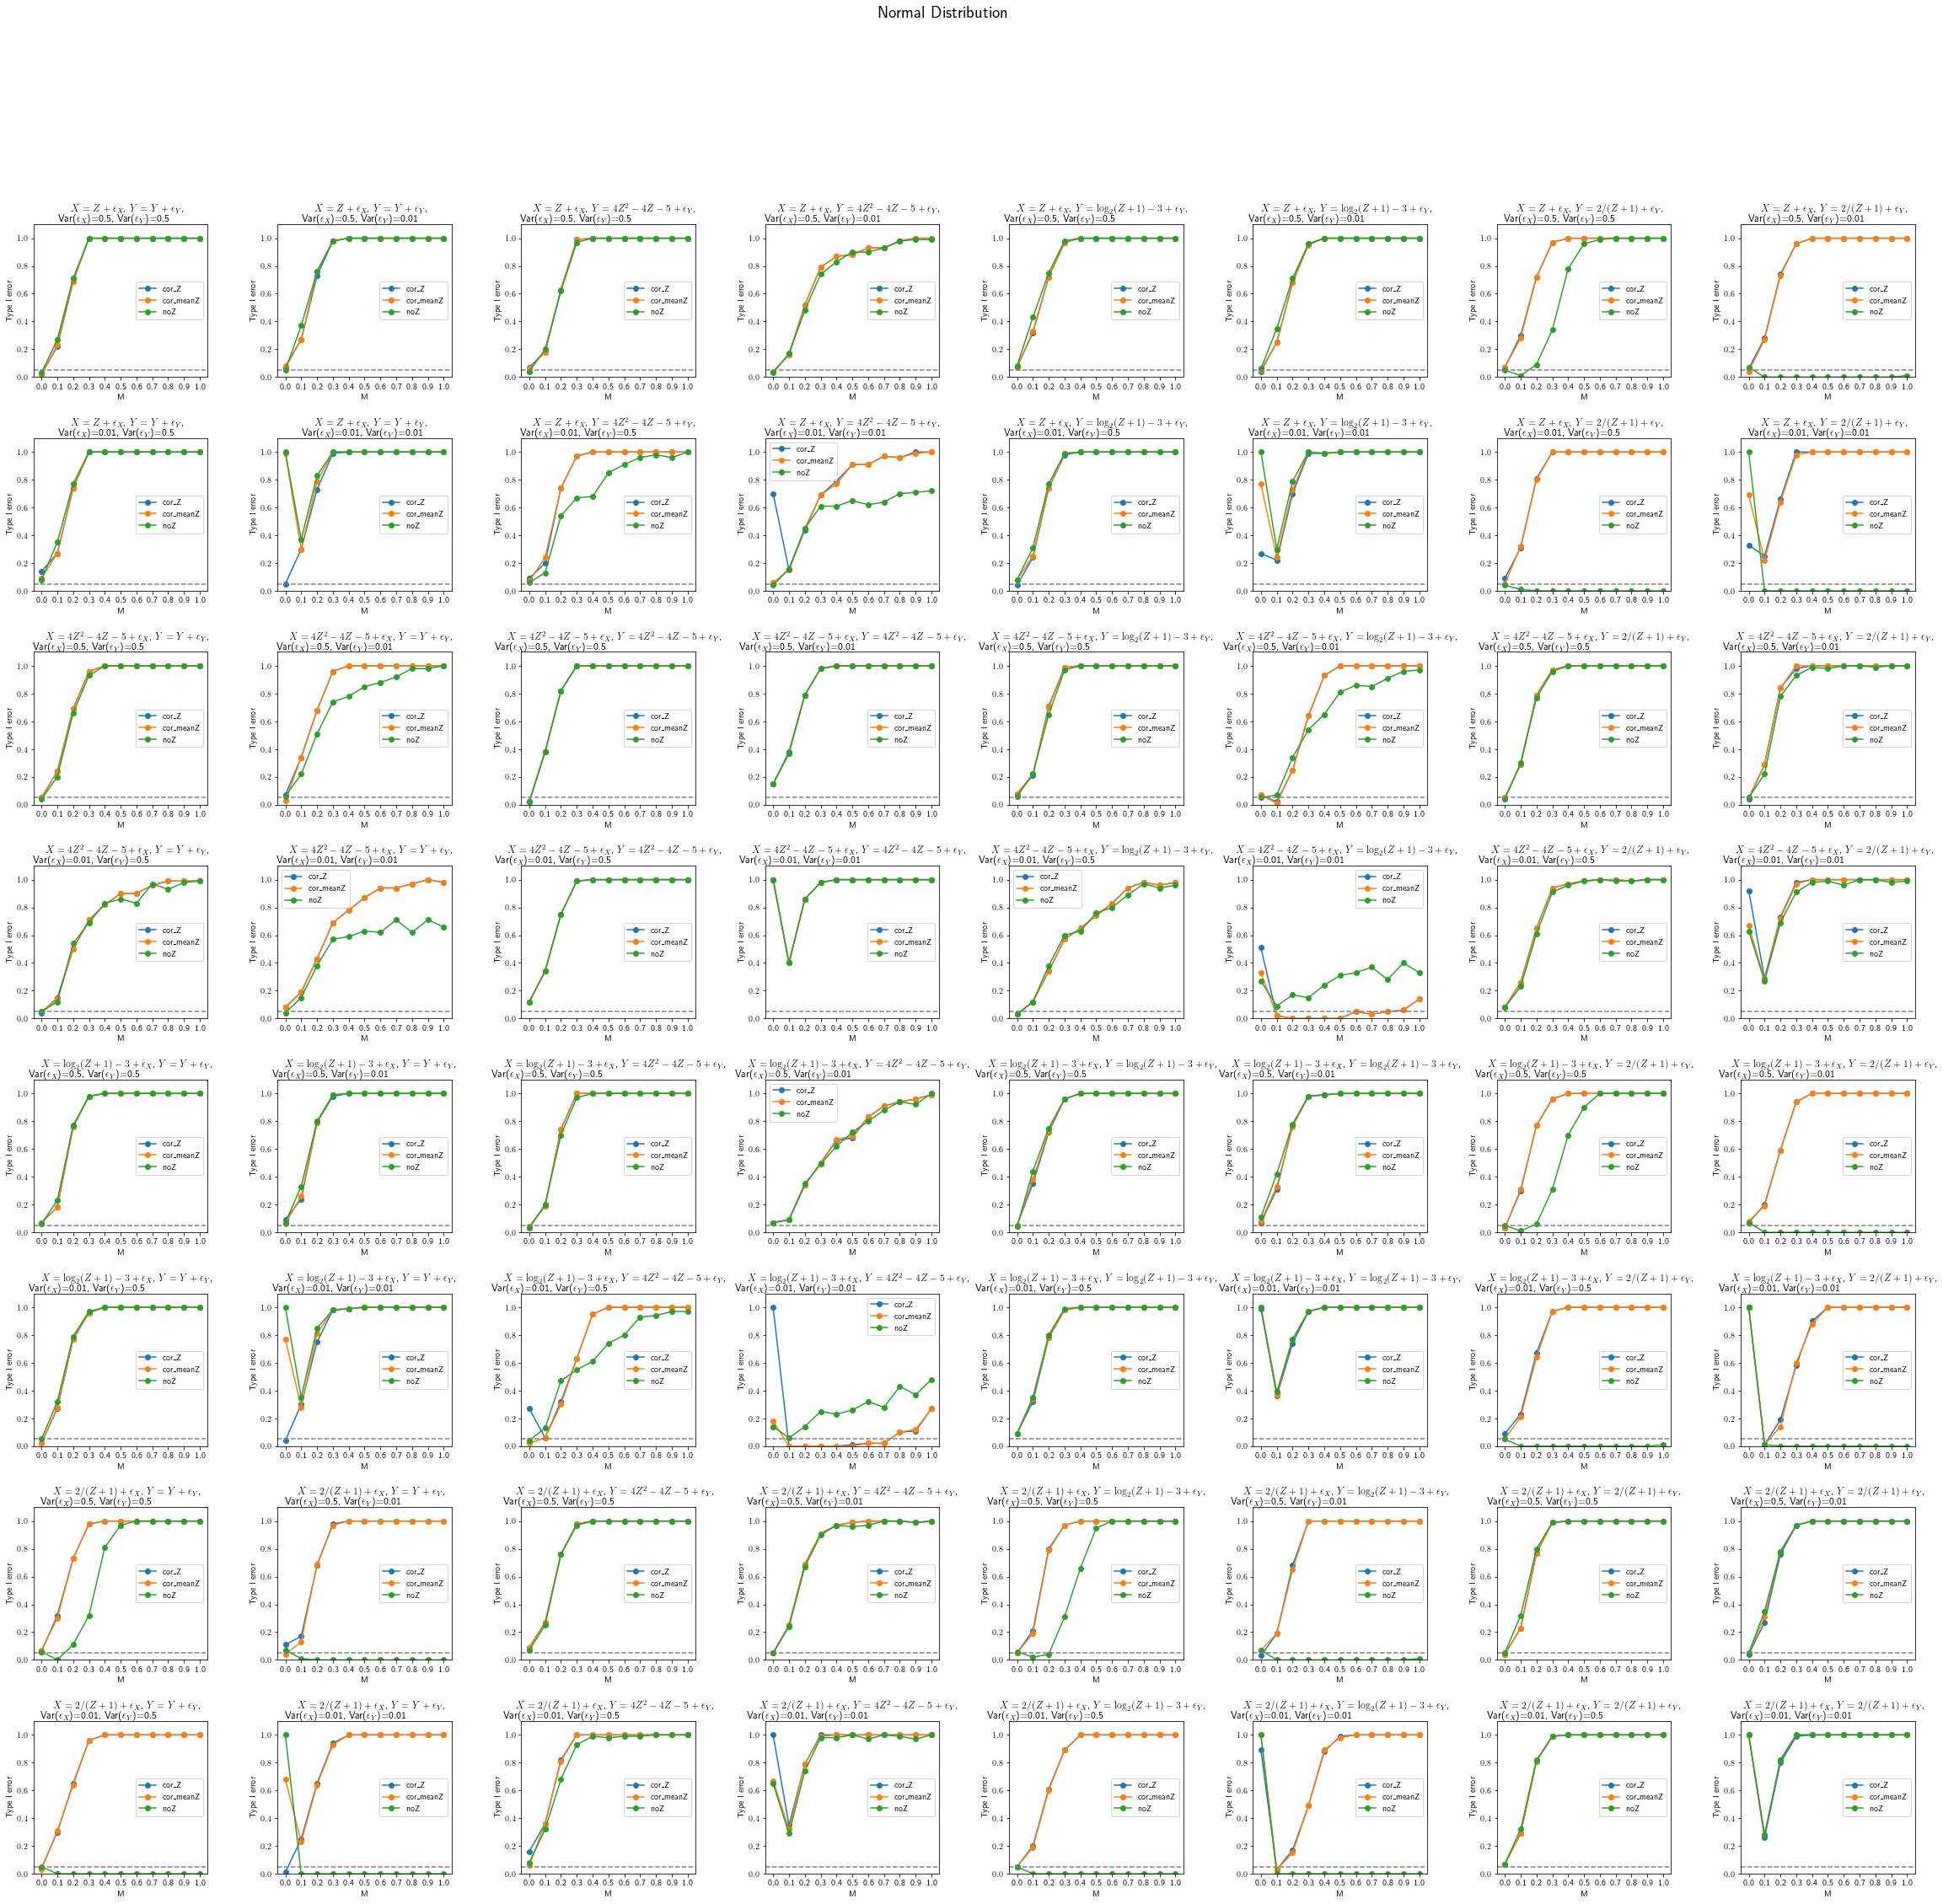

In [7]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(40, 36))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(4):
    for yf in range(4):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(8, 8, xf*16+vx1*8+yf*2+vy1+1)
                result = pd.read_csv("./results/result_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[:3,:]
                plt.plot(result.T, '-o')
                plt.xlabel("M")
                if hs == "h0":
                    plt.ylabel("Type I error")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

## Comparing cor_Z and XY_Z

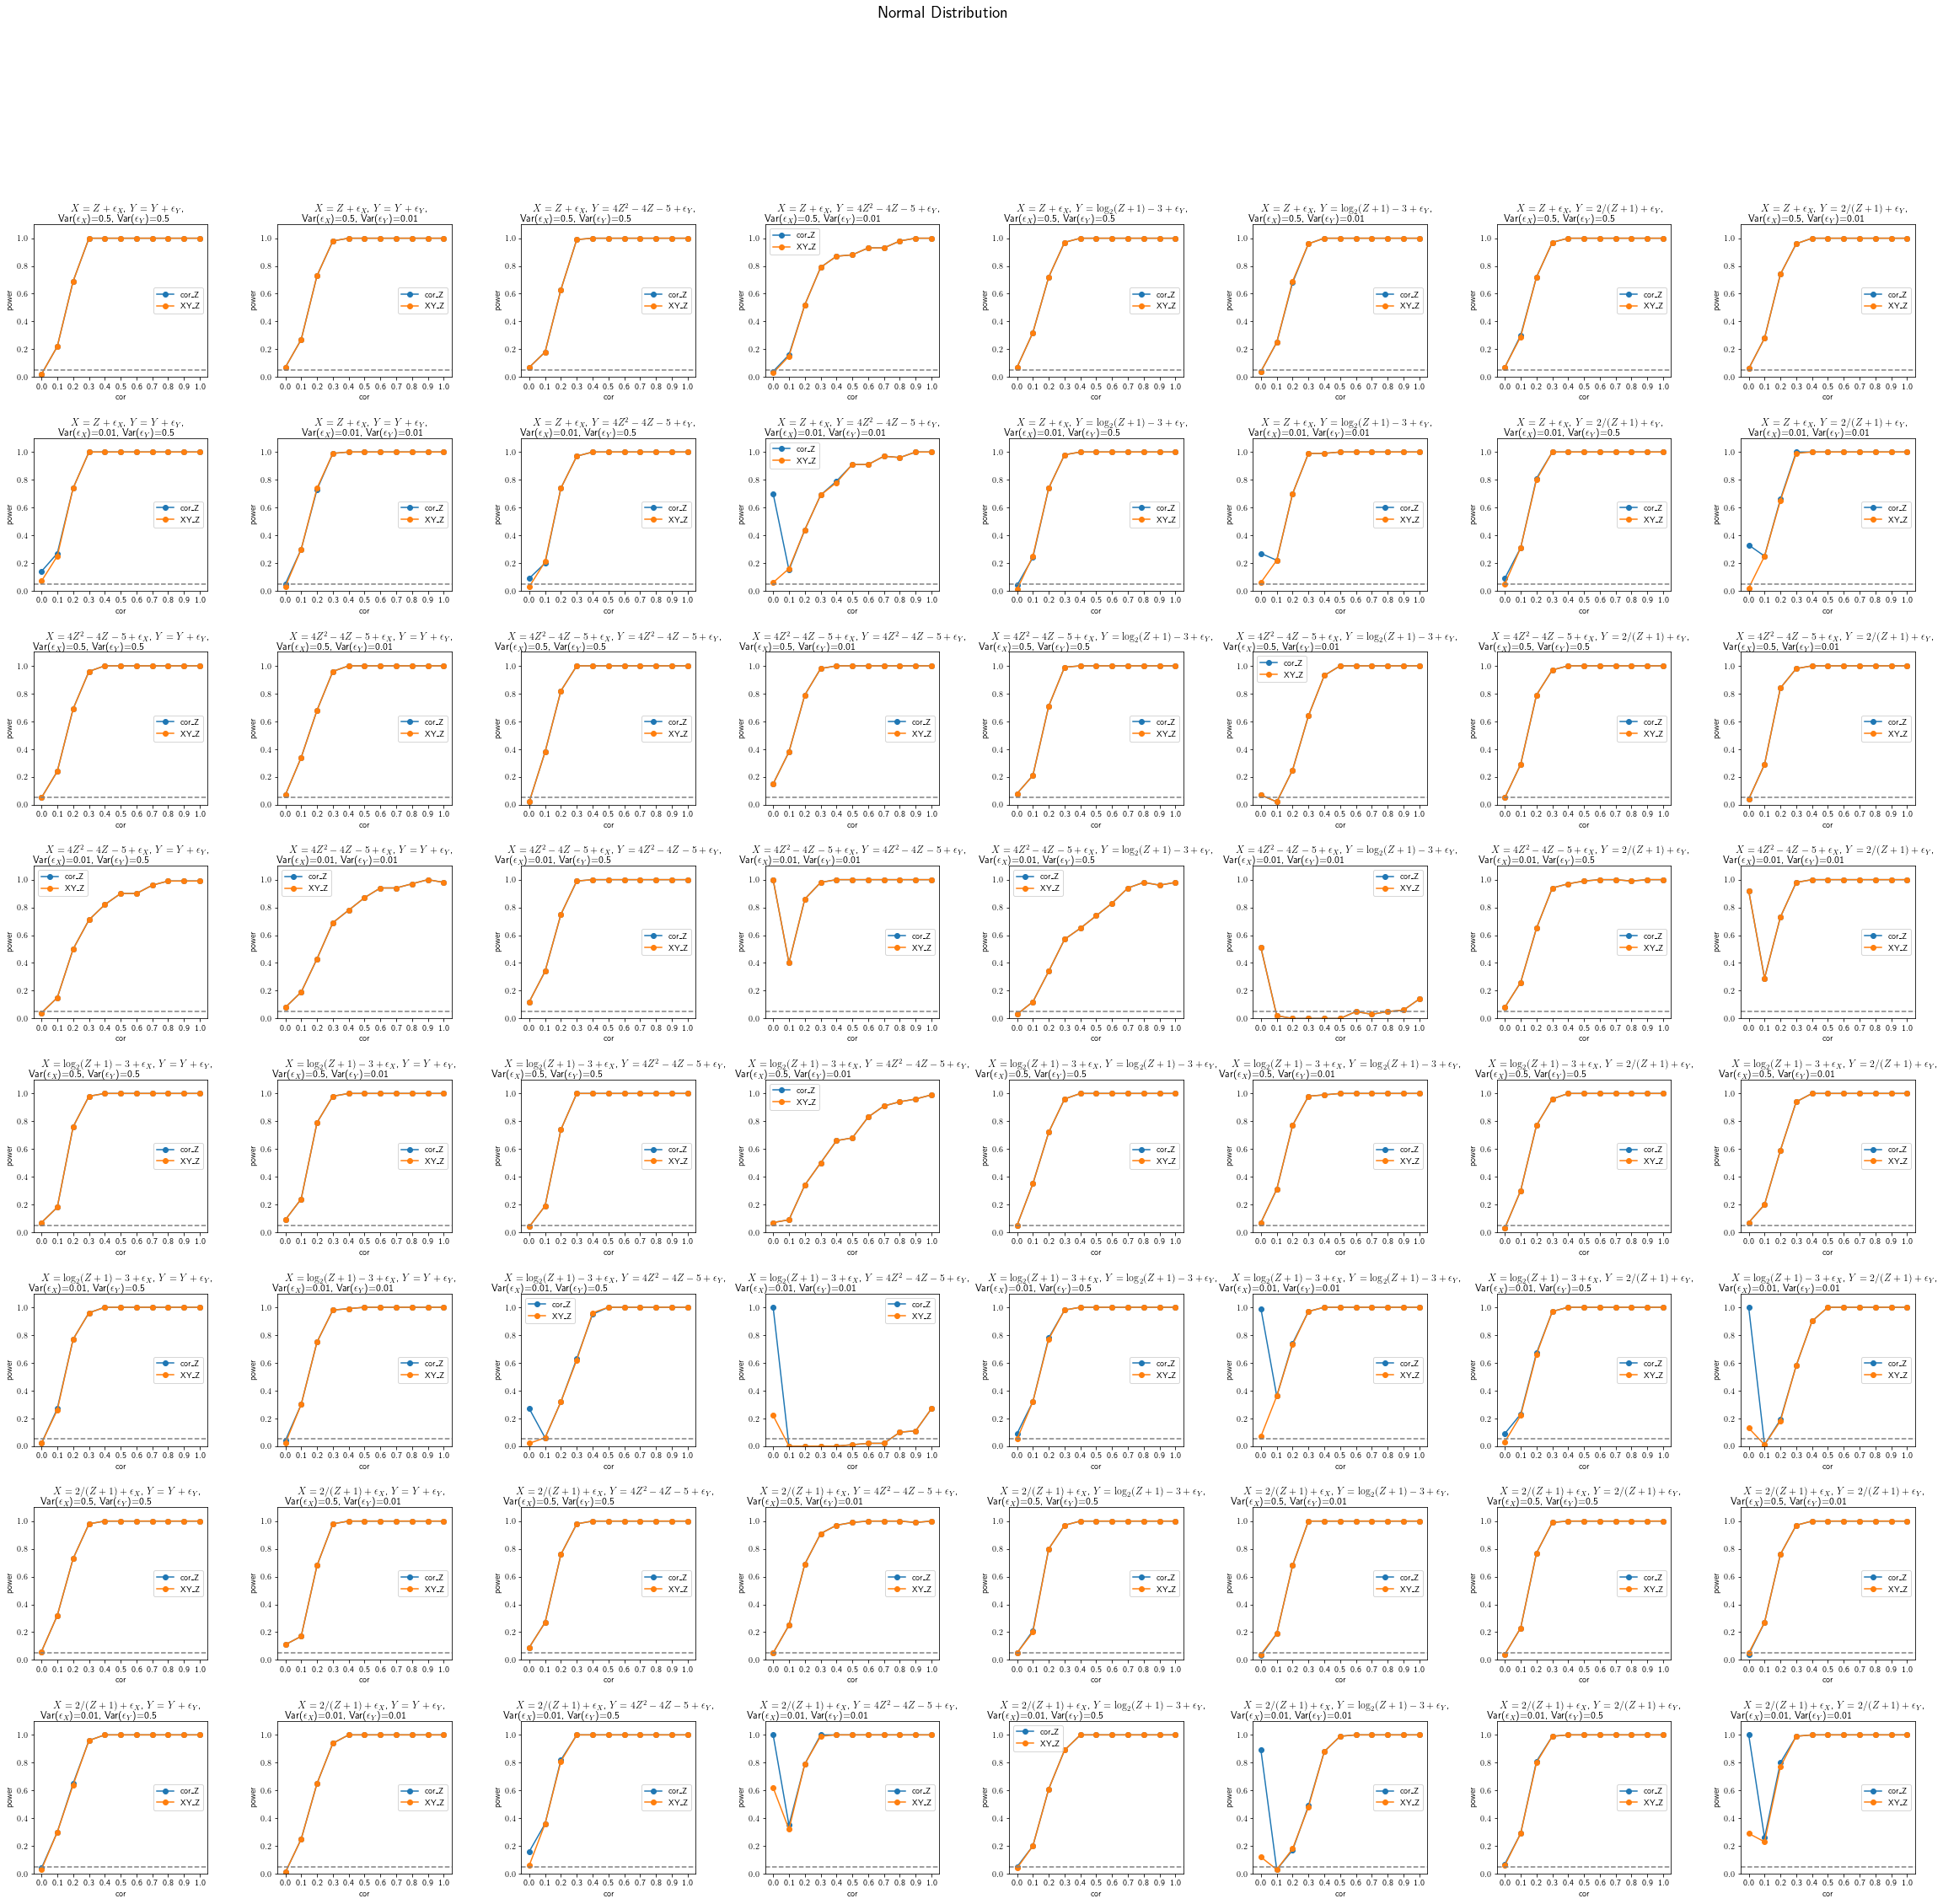

In [54]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(40, 36))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(4):
    for yf in range(4):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(8, 8, xf*16+vx1*8+yf*2+vy1+1)
                result = pd.read_csv("./results/result_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

## Comparing type-1 error and power between using information of $Z$ or not

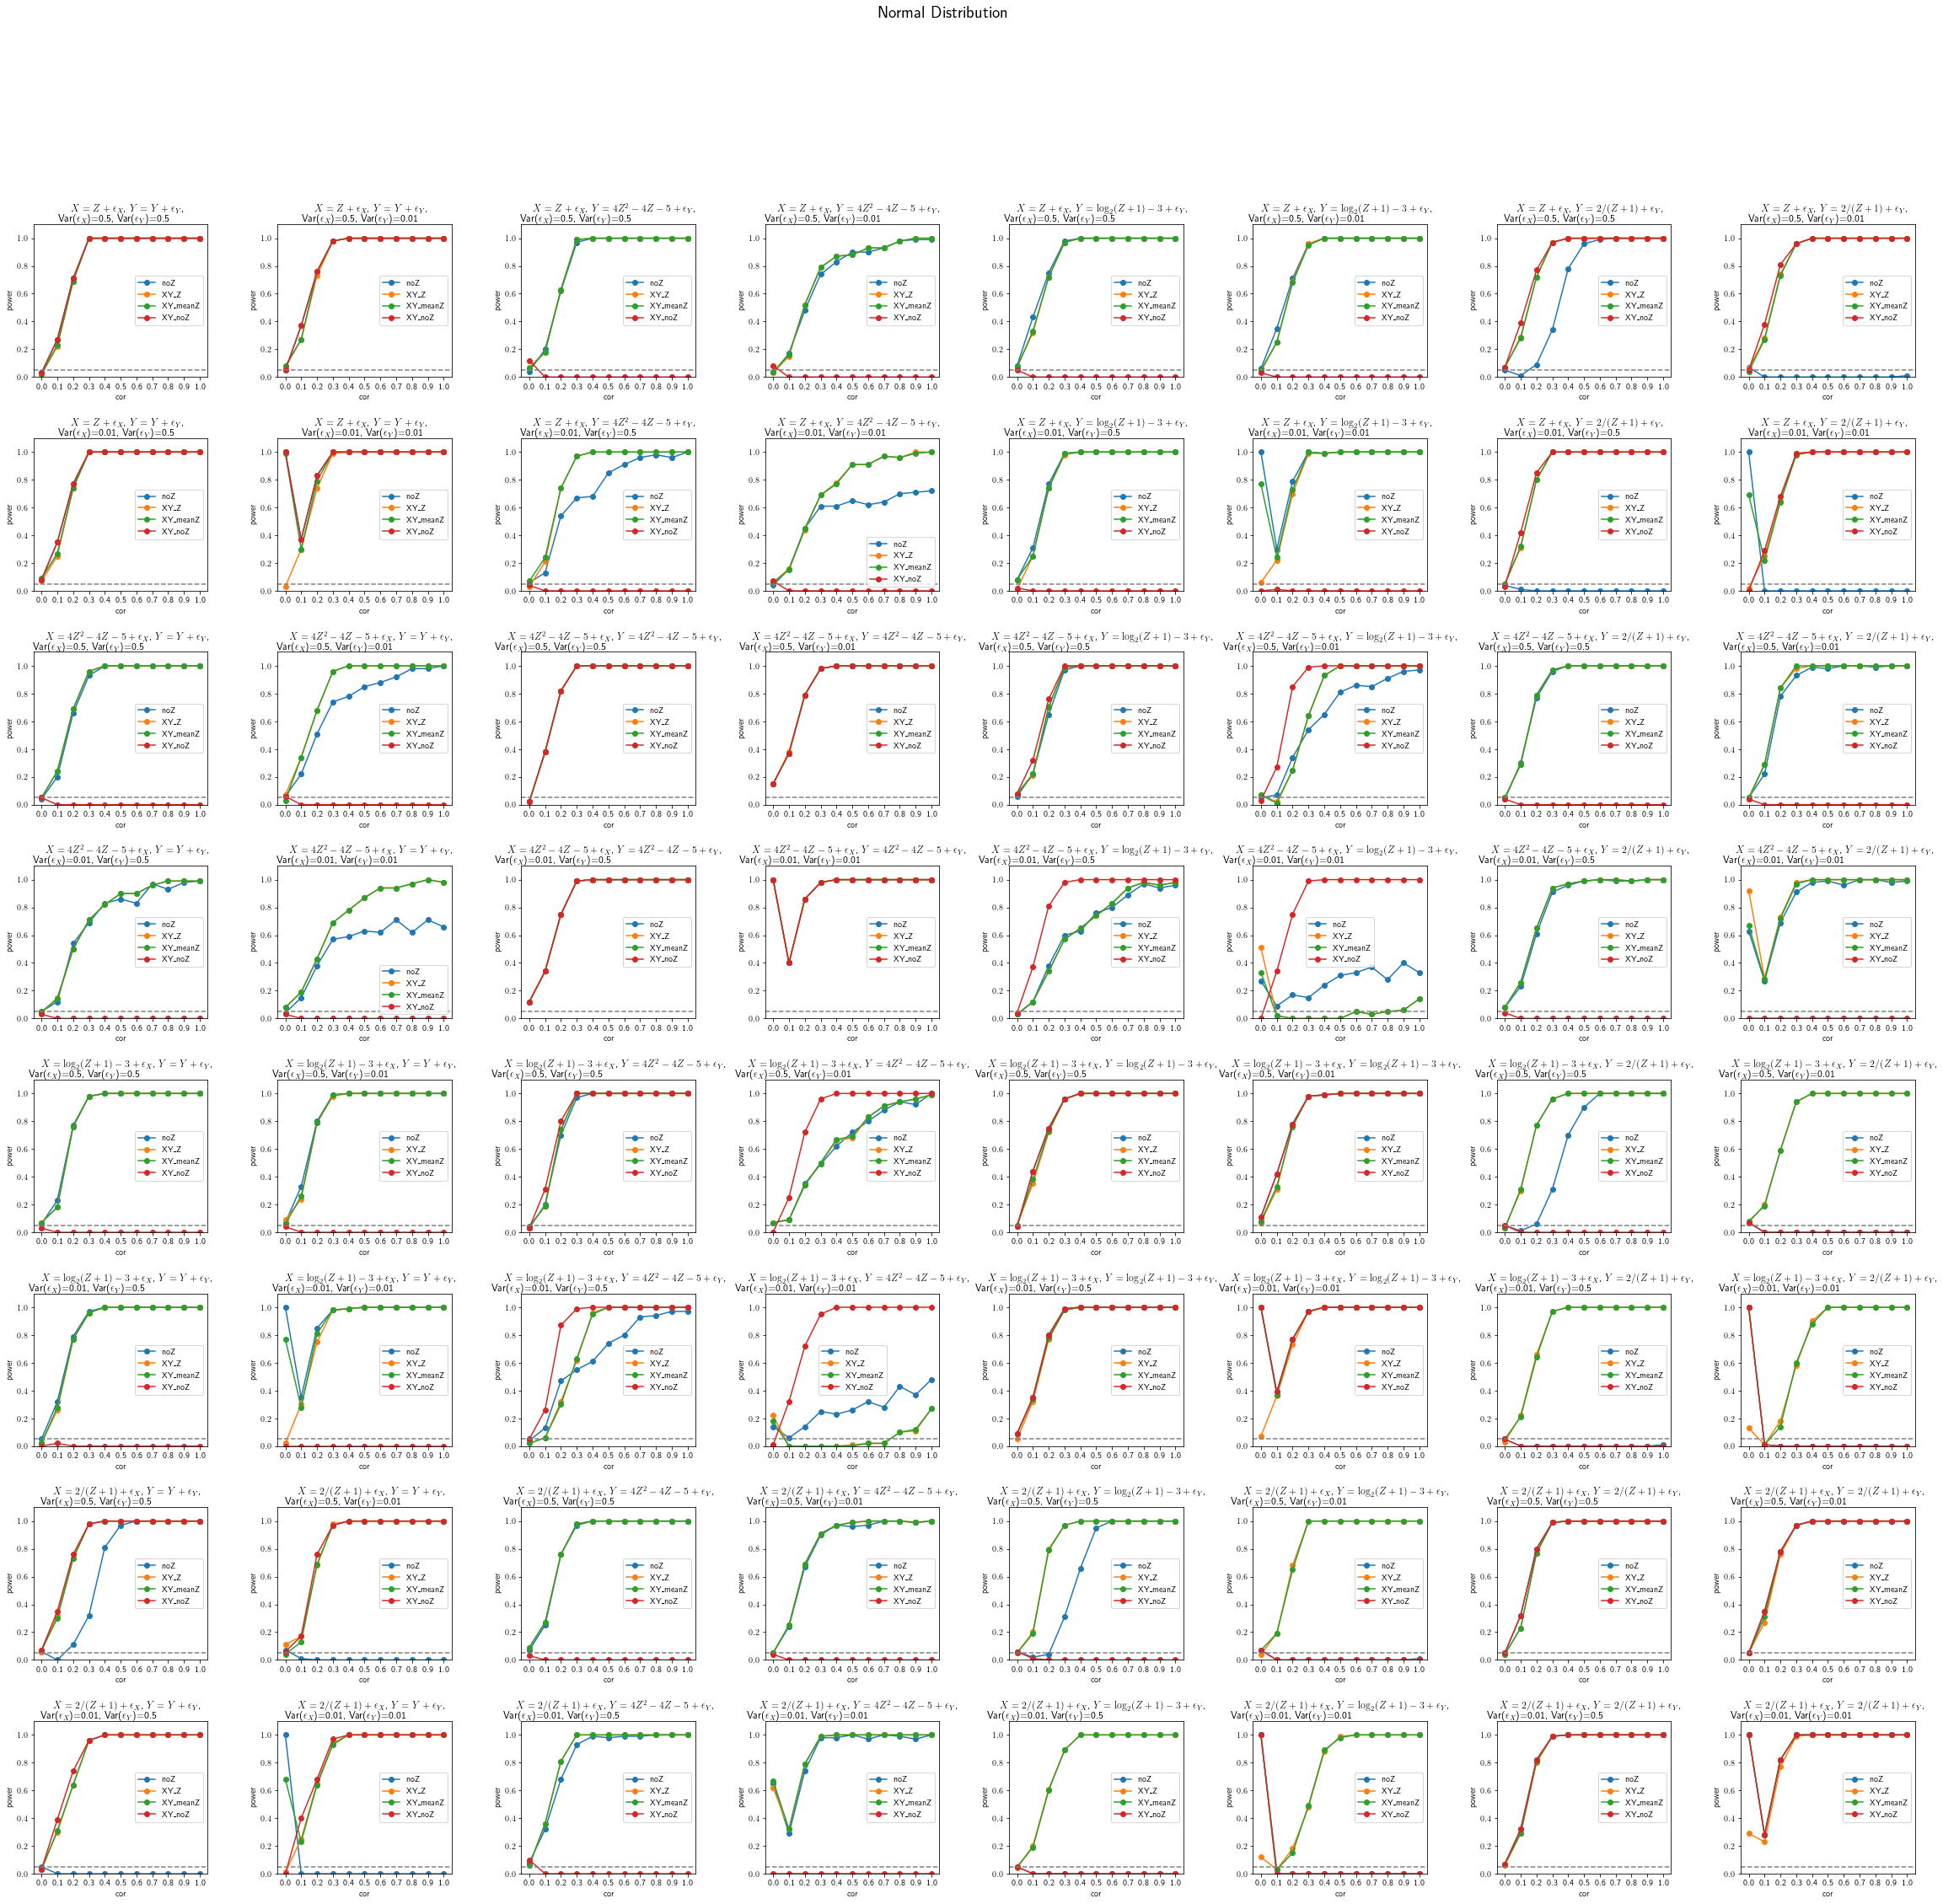

In [80]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(40, 36))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(4):
    for yf in range(4):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(8, 8, xf*16+vx1*8+yf*2+vy1+1)
                result = pd.read_csv("./results/result_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[2,3,4,5],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

## Comparing XY_Z and XY_meanZ

 - large N=1000

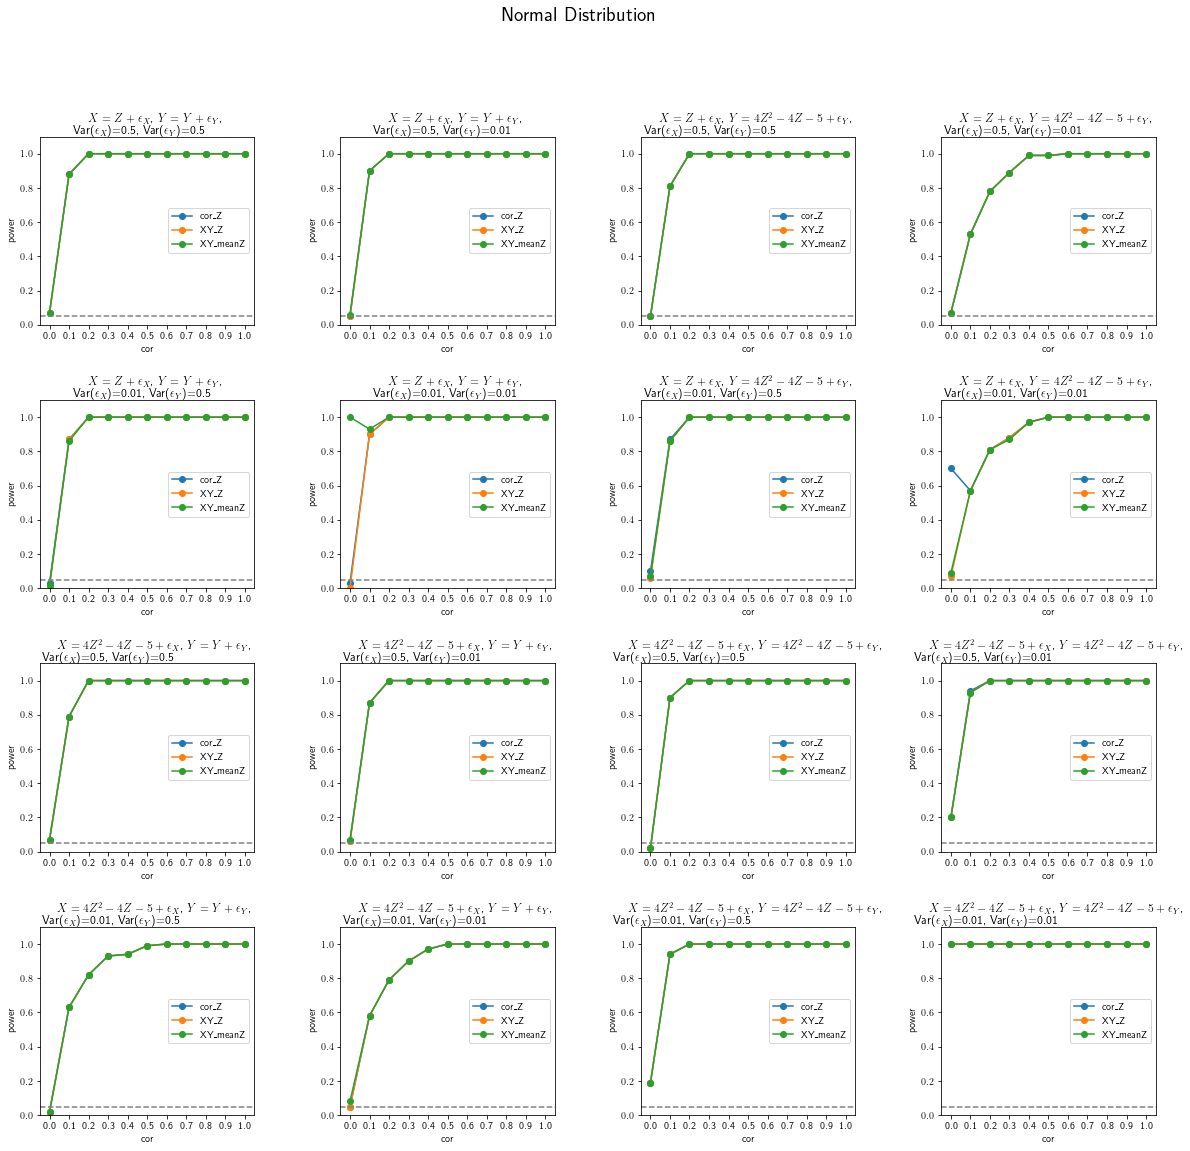

In [83]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

 - large N=1000 + distribution="skewed_normal"

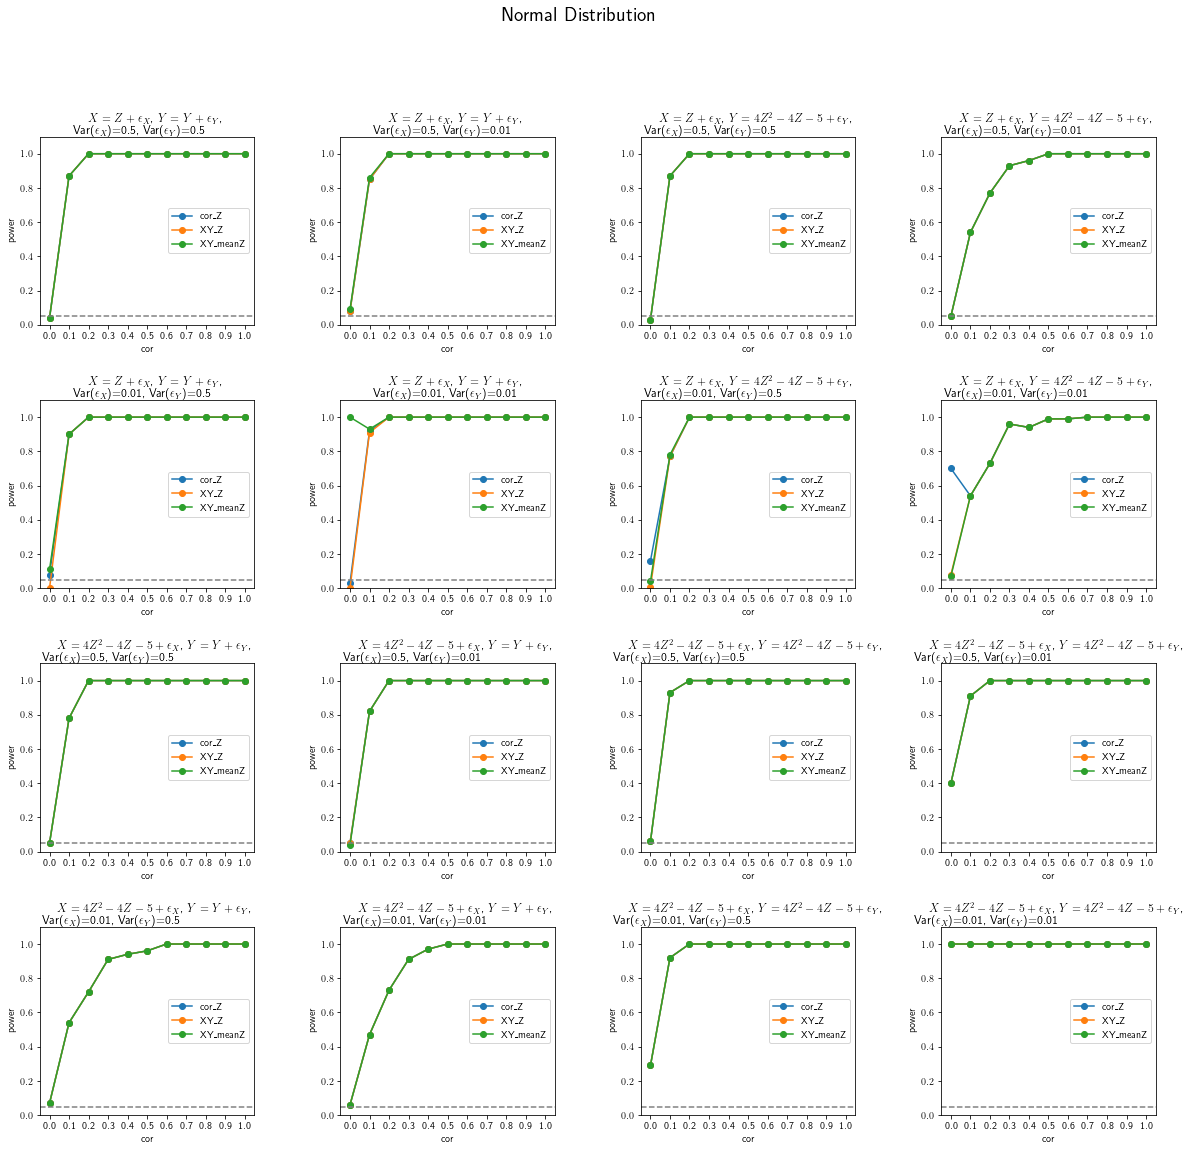

In [12]:
types = "skewed_normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

 - large N=1000 + distribution="skewed_normal" + nonlinear function in $Z$

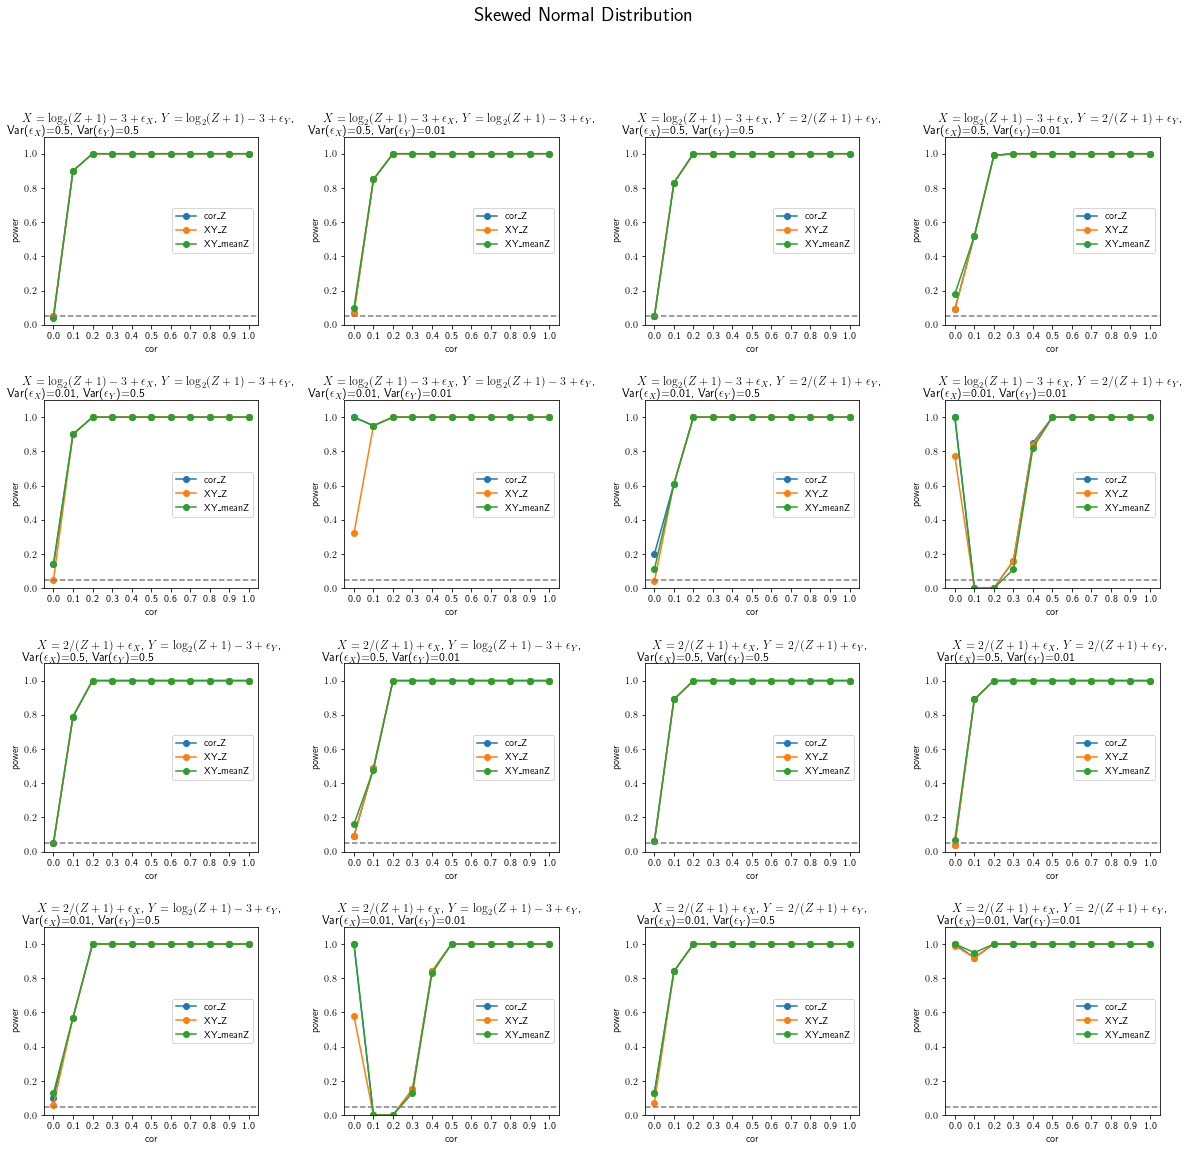

In [13]:
types = "skewed_normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m50_all_x_func_"+str(xf+2)+"_"+str(yf+2)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf+2], yfuns[yf+2], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Skewed Normal Distribution", fontsize=20)
plt.show()

 - M=25

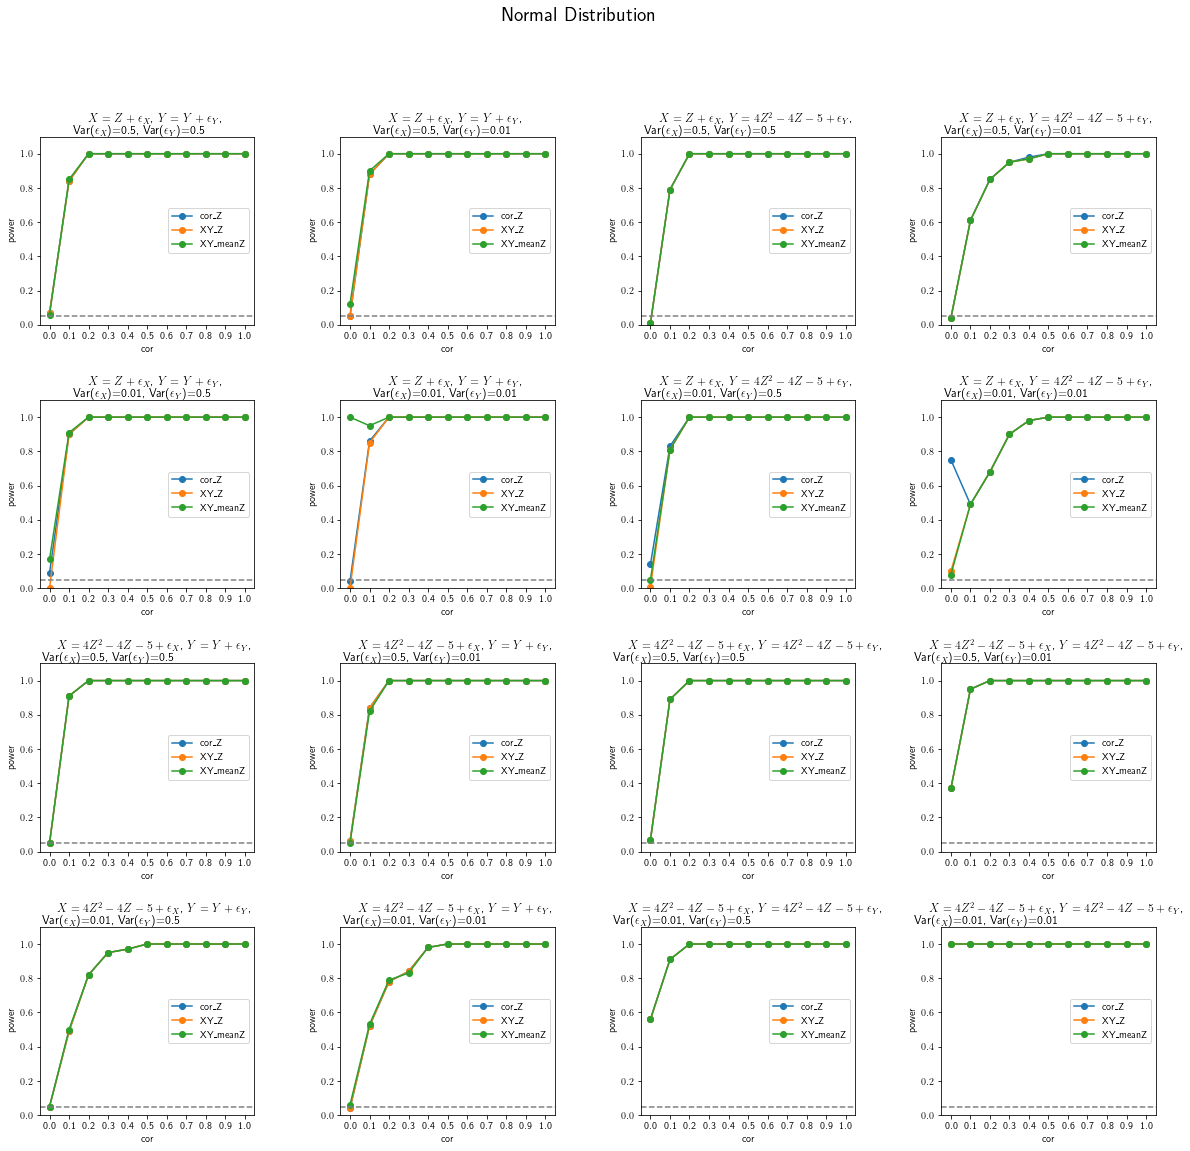

In [14]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m25_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

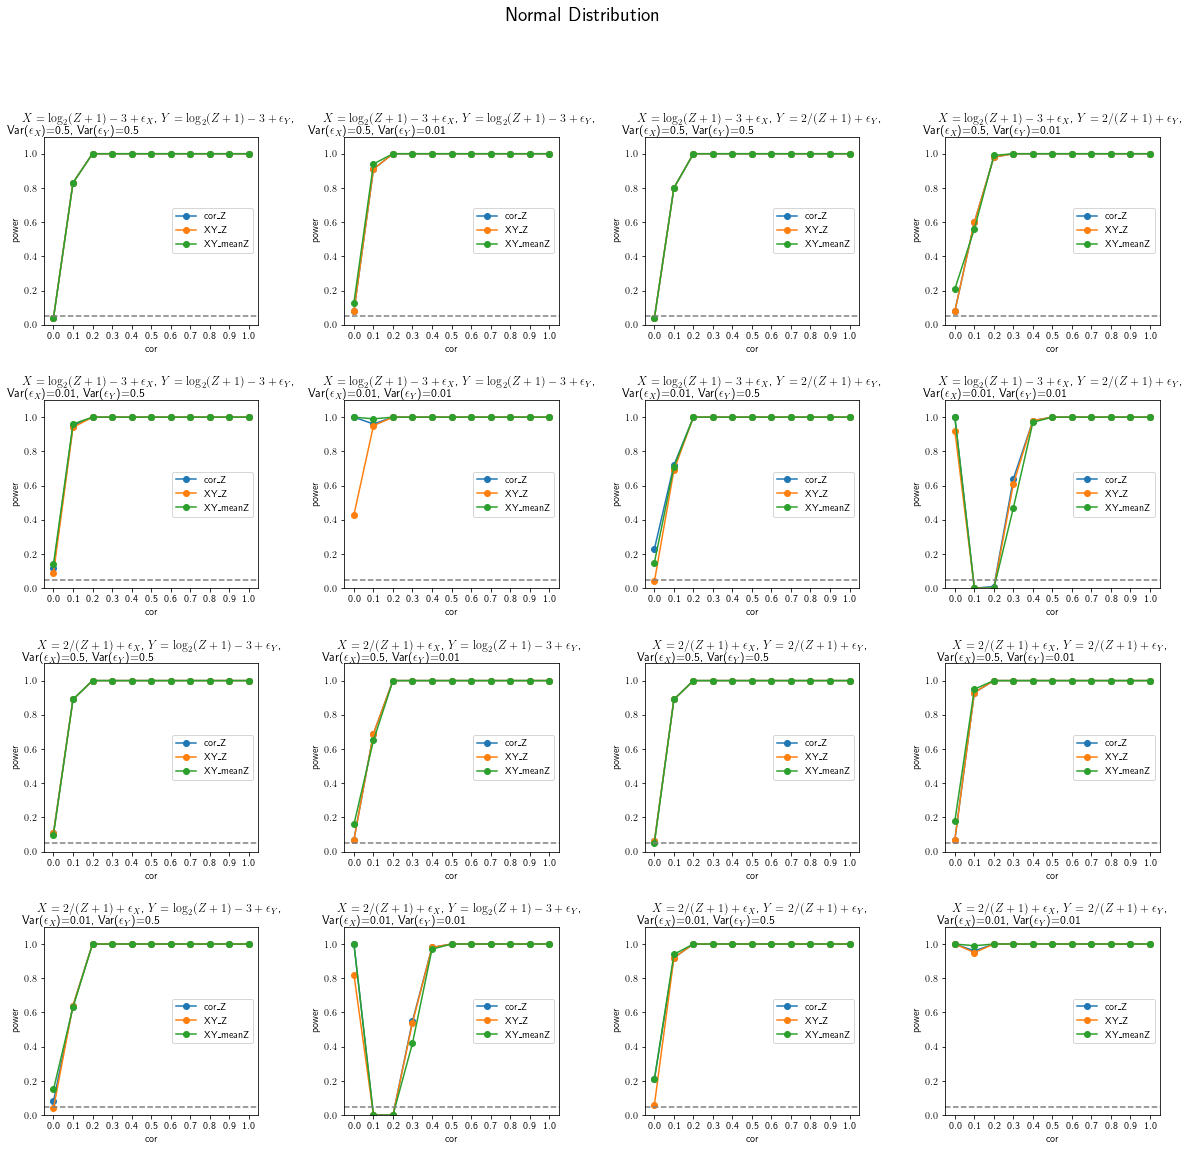

In [15]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m25_all_x_func_"+str(xf+2)+"_"+str(yf+2)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf+2], yfuns[yf+2], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

 - M = 10

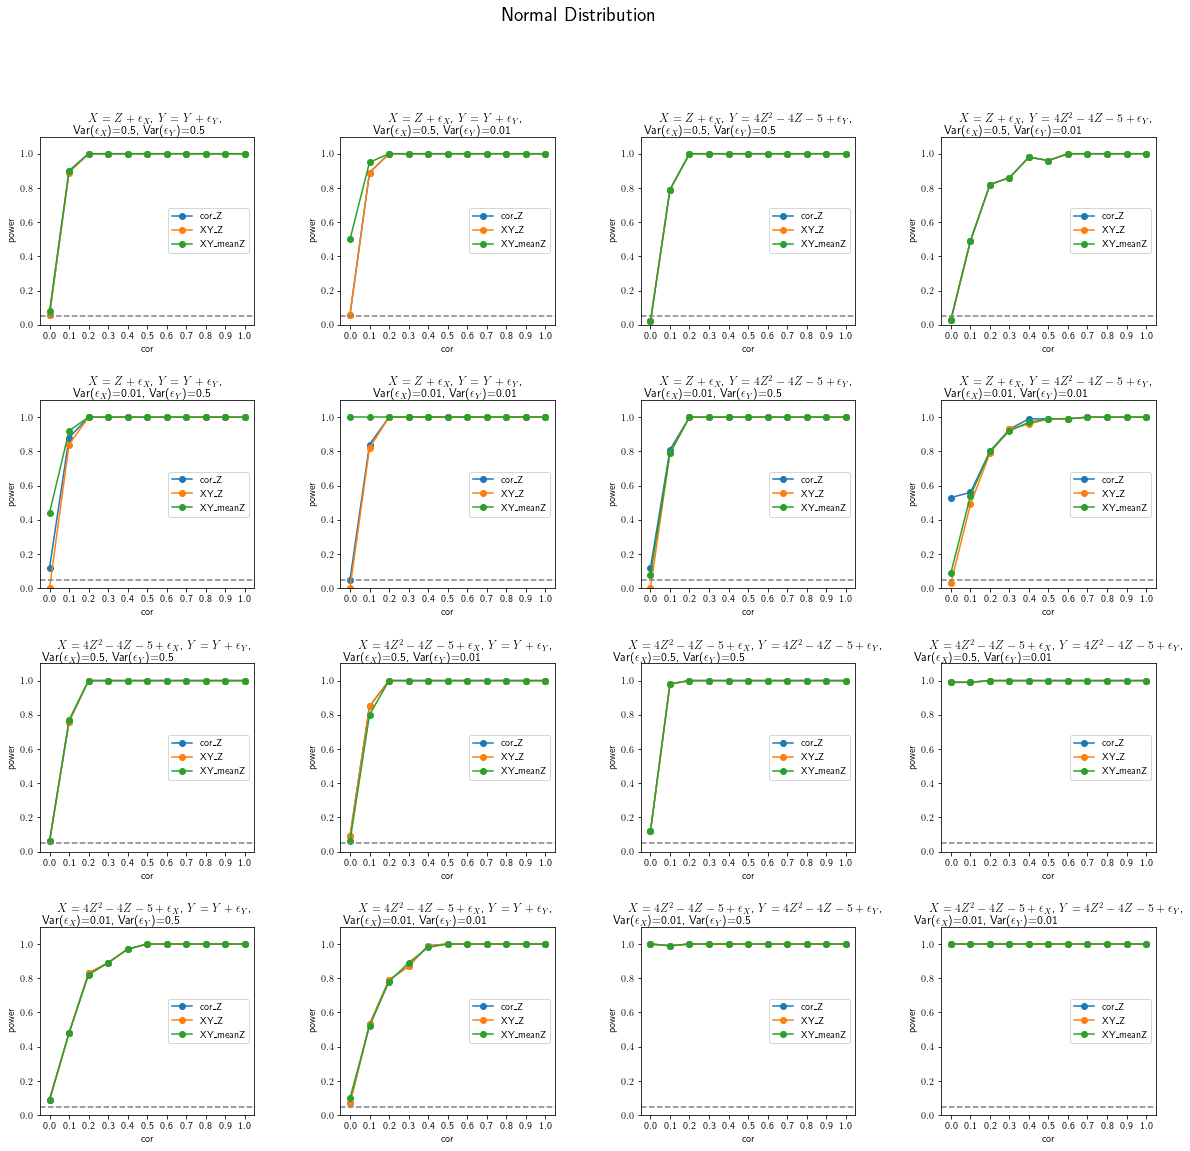

In [94]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m10_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

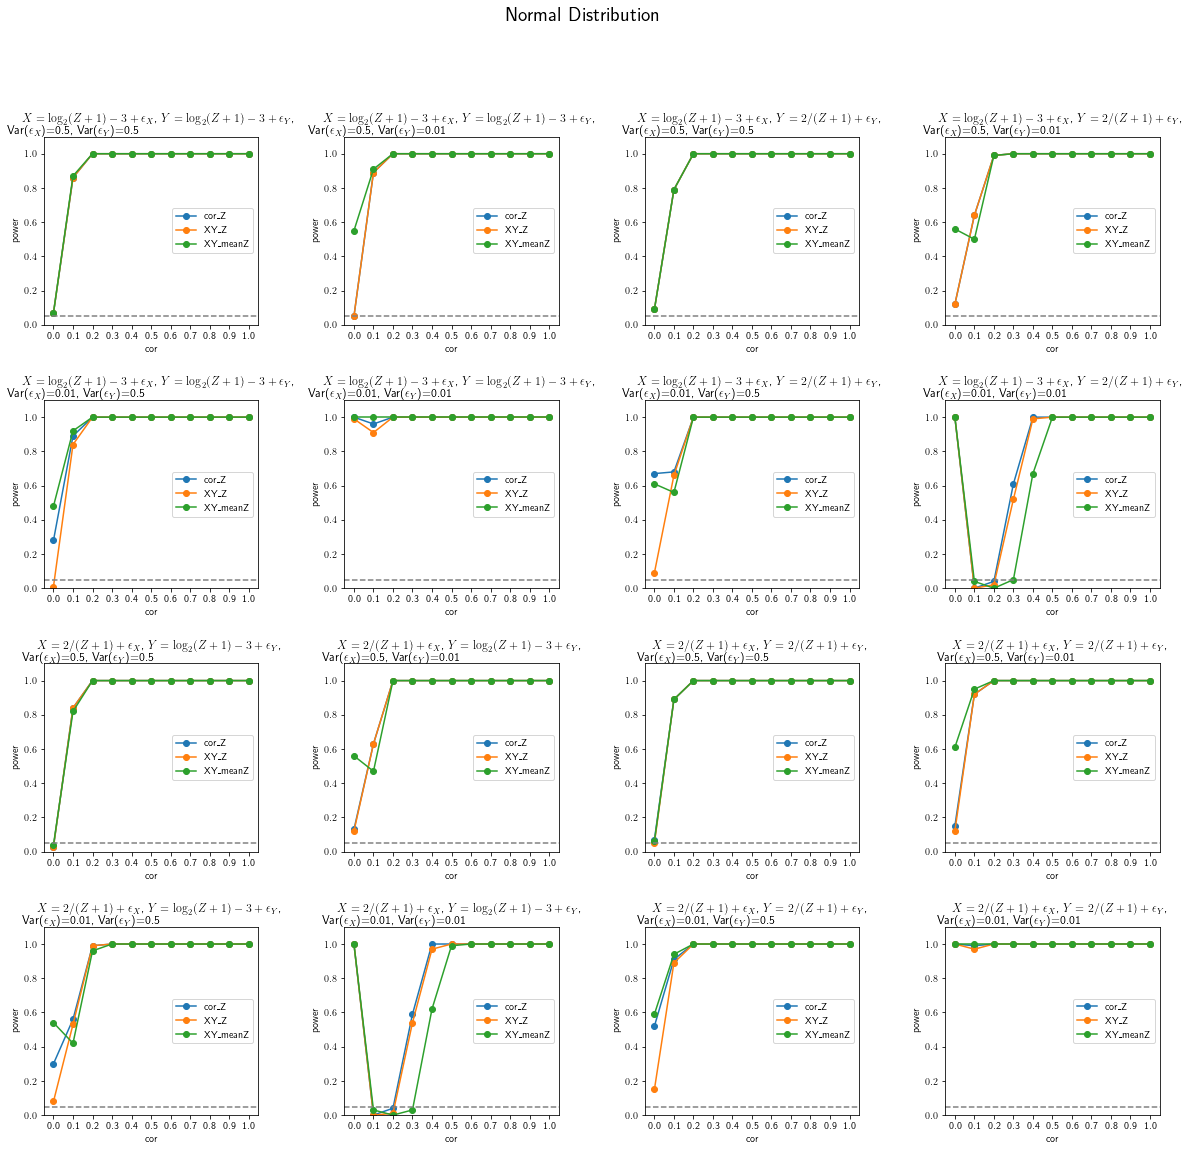

In [95]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n1000_m10_all_x_func_"+str(xf+2)+"_"+str(yf+2)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf+2], yfuns[yf+2], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

## More statistics

 - new conditional correlation coefficient by Mona Azadkia & Sourav Chatterjee (2021)
 $$
 T = T(X,Y|Z) = \frac{\int\mathbb{E}(\textrm{Var}(\mathbb{P}(X\geq t|Y,Z)|Z))d\mu(t)}{\int\mathbb{E}(\textrm{Var}(1_{\{X\geq t\}}|Z))d\mu(t)}
 $$
 $$
 T_n = T_n(X,Y|Z) = \frac{\sum_{i=1}^n(\min\{R_i, R_{M(i)}\}-\min\{R_i,R_{N(i)}\})}{\sum_{i=1}^n(R_i-\min\{R_i,R_{N(i)}\})}
 $$
 where $N(i)$ is the index of nearest to $Z_i$, $M(i)$ is the index of nearest to $(Z_i, Y_i)$ and $R_i$ is the rank of $X_i$.

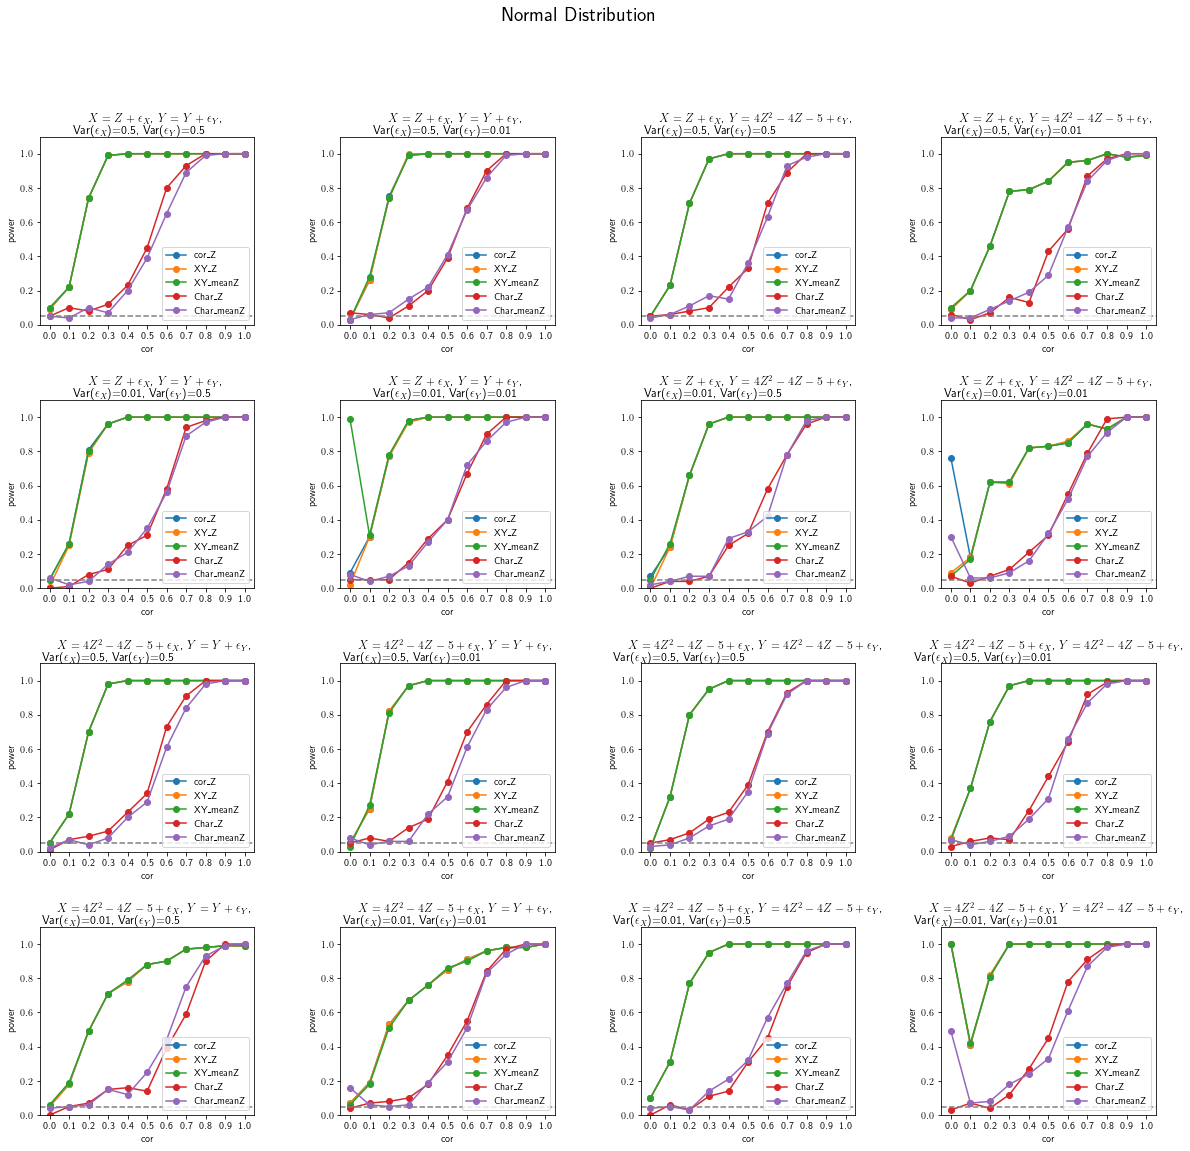

In [3]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n200_m50_all_x_func_"+str(xf)+"_"+str(yf)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3,5,6],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf], yfuns[yf], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()

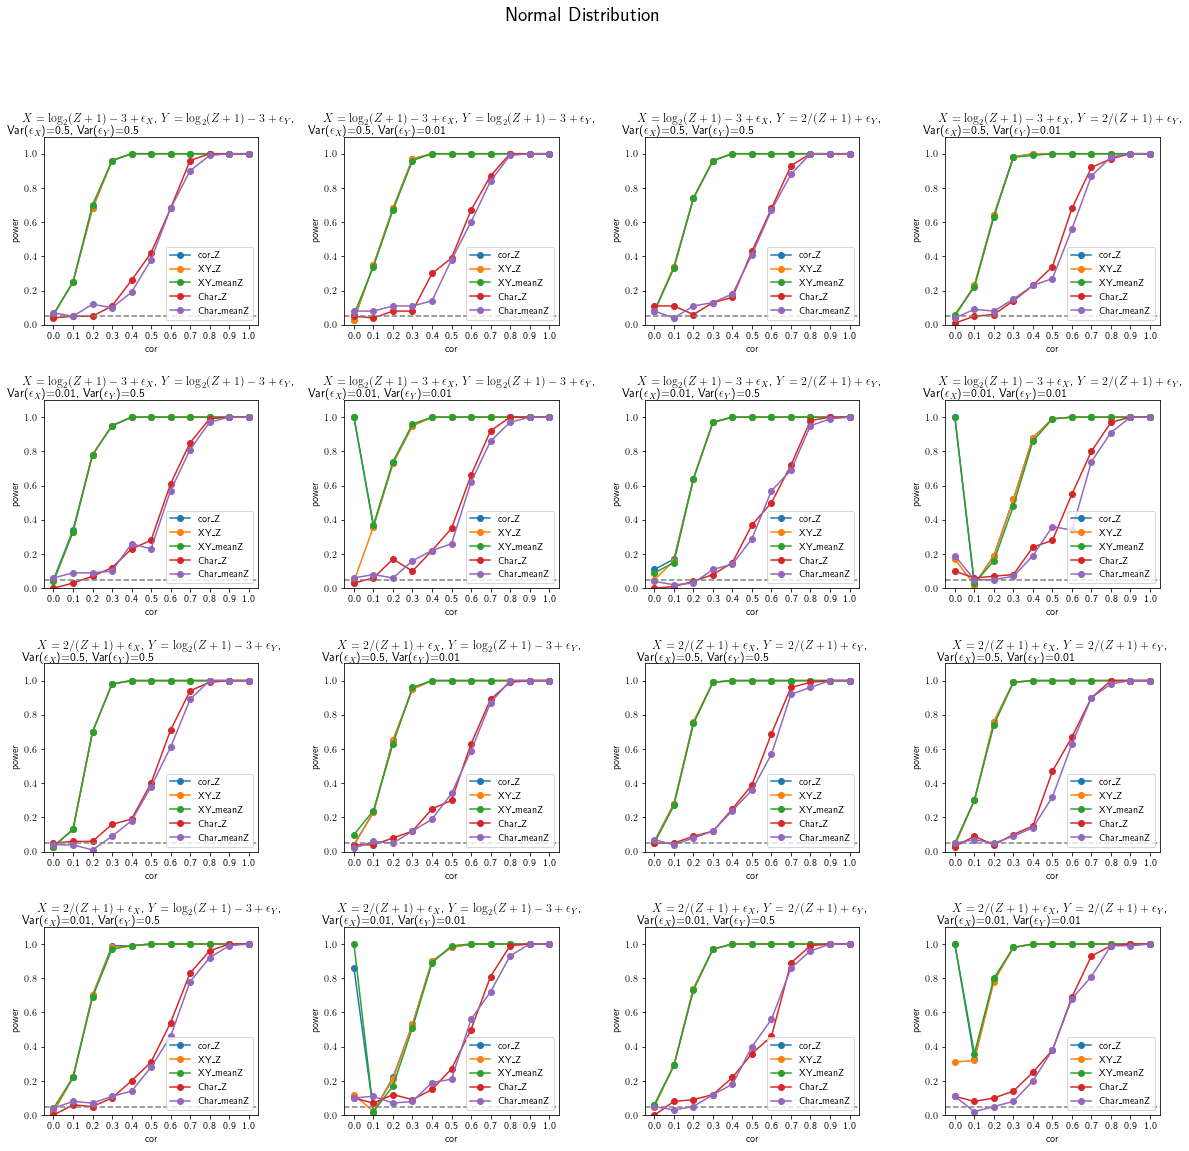

In [4]:
types = "normal"
hs = 'h0'
vxs = [0.5, 0.01]
vys = [0.5, 0.01]
xfuns = ['$X = Z + \epsilon_X$', '$X = 4Z^2 - 4Z-5 + \epsilon_X$', '$X = \log_2(Z+1)-3 + \epsilon_X$', '$X = 2/(Z+1) + \epsilon_X$']
yfuns = ['$Y = Y + \epsilon_Y$', '$Y = 4Z^2 - 4Z-5 + \epsilon_Y$', '$Y = \log_2(Z+1)-3 + \epsilon_Y$', '$Y = 2/(Z+1)  + \epsilon_Y$']
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=.4, hspace=.4)
for xf in range(2):
    for yf in range(2):
        for vx1 in range(len(vxs)):
            for vy1 in range(len(vys)):
                plt.subplot(4, 4, xf*8+vx1*4+yf*2+vy1+1)
                result = pd.read_csv("./results/result_n200_m50_all_x_func_"+str(xf+2)+"_"+str(yf+2)+"_var_"+str(vxs[vx1])+"_"+str(vys[vy1])+"_"+hs+"_"+types+".csv", index_col=0)
                result = result.iloc[[0,2,3,5,6],:]
                plt.plot(result.T, '-o')
                plt.xlabel("cor")
                if hs == "h0":
                    plt.ylabel("power")
                else:
                    plt.ylabel("power")
                plt.legend(result.index)
                plt.ylim([0, 1.1])
                plt.axhline(y=0.05, color='grey', linestyle='--')
                plt.rcParams['text.usetex'] = True
                plt.title(r"{}, {}, $\\$ Var($\epsilon_X$)={}, Var($\epsilon_Y$)={}".format(xfuns[xf+2], yfuns[yf+2], vxs[vx1], vys[vy1]))
                #plt.xticks(result.columns, np.arange(11)/10)
fig = plt.gcf()
fig.suptitle("Normal Distribution", fontsize=20)
plt.show()